## Importing stuff I need

In [1]:
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import time, os
from IPython import display

from pixell import enmap,utils as putils,reproject,enplot
from pixell.lensing import phi_to_kappa
from pixell.reproject import healpix2map,thumbnails
from pixell.curvedsky import alm2map,map2alm,almxfl

import numpy as np
import matplotlib.pyplot as plt

import healpy as hp
from healpy.fitsfunc import read_alm,read_map

import symlens as s
from symlens import utils as sutils

# utils require orphics + pyfisher + enlib
from falafel import qe, utils
import pytempura 

from orphics import cosmology, io

# my own file
import websky_stack_and_visualize as josh_websky

## Reading and opening files

In [2]:
# simulated maps file location
alm_filename = "../lensed_alm.fits"

alm_hp = read_alm(alm_filename)
print("alms: ", alm_hp.dtype, len(alm_hp))

# lensing convergence file
kap_filename = "kap.fits"

# don't need kappa map right now?

alms:  complex128 34043626


## Theory from orphics (from falafel/utils.py)

In [3]:
PATH_TO_FALAFEL = "/home/joshua/research/falafel"
config = io.config_from_yaml(PATH_TO_FALAFEL + "/input/config.yml")
thloc = PATH_TO_FALAFEL + "/data/" + config['theory_root']

theory = cosmology.loadTheorySpectraFromCAMB(thloc,get_dimensionless=False)

## Convert cell to pixell (equatorial CAR) format

In [4]:
# 0.5 (1 for now) arcmin resolution car geometry
shape, wcs = enmap.fullsky_geometry(res=np.deg2rad(1.5 / 60.))
# create empty map to overlay our map
omap = enmap.empty(shape, wcs, dtype=np.float32)
t1 = time.time()
alm_px = alm2map(alm_hp, omap)
t2 = time.time()
print("Took %0.5f seconds." % (t2 - t1))

Took 2.87075 seconds.


## Prepare appropriate data

In [5]:
LMIN = 300
LMAX = 6000

alms = map2alm(alm_px, lmax=LMAX)

# if i set beam to 1.0 does that include zero effect from the beam?
beam_fwhm = 1.5 # arcmin
noise_t = 10. # noise stdev in uK-arcmin
# ucls['TT'] = C_ell_TT
# tcls['TT'] = C_ell_TT + N_ell_TT 
ucls, tcls = utils.get_theory_dicts_white_noise(beam_fwhm, noise_t)

# filter map
# isotropic_filter(alm, tcls, lmin, lmax, ignore_te=True)
fTalm = utils.isotropic_filter([alms, alms*0., alms*0.],
                                tcls, LMIN, LMAX, ignore_te=True)[0]

# deconvolve beam
# fTalm = almxfl(fTalm, 1.0 / maps.gauss_beam(ells, beams_fwhm))

fTalm.shape


(18009001,)

## Running reconstruction and getting output map

In [6]:
ests = ['TT']

px = qe.pixelization(shape=shape, wcs=wcs)

recon_alms = qe.qe_all(px, ucls, fTalm=fTalm, fEalm=fTalm*0., fBalm=fTalm*0.,
                       mlmax=LMAX, estimators=ests)

recon_map_only = alm2map(phi_to_kappa(recon_alms['TT'][0].astype(np.complex128)),
                         enmap.empty(shape, wcs, dtype=np.float32))
#qe.qe_all?

## Normalization

In [7]:
kappa_norms = pytempura.get_norms(ests, ucls, tcls, LMIN, LMAX, k_ellmax=LMAX, no_corr=False)

# first index for the gradient
print(recon_alms['TT'].shape)
print(kappa_norms['TT'].shape)

kappa_alms = phi_to_kappa(almxfl(recon_alms['TT'][0].astype(np.complex128),
                                 kappa_norms['TT'][0]))

kappa_map = alm2map(kappa_alms, enmap.empty(shape, wcs, dtype=np.float32))
print(kappa_map.shape)


(2, 18009001)
(2, 6001)
(7201, 14400)


## Plotting output map

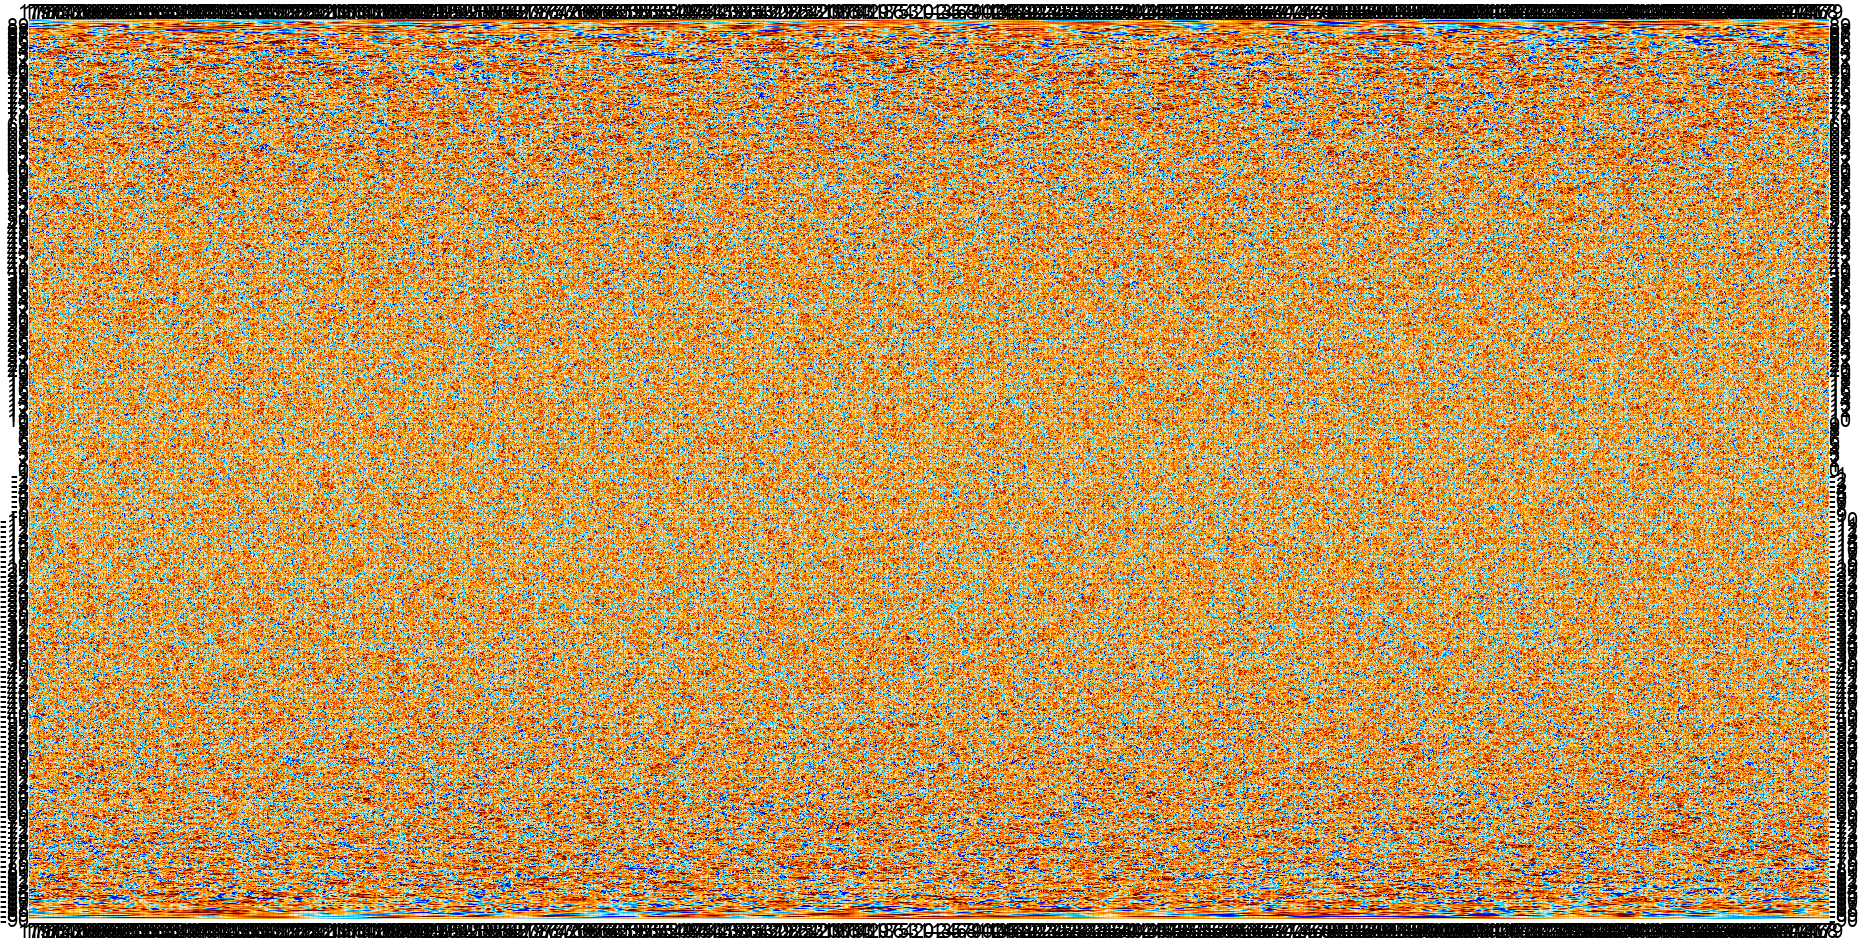

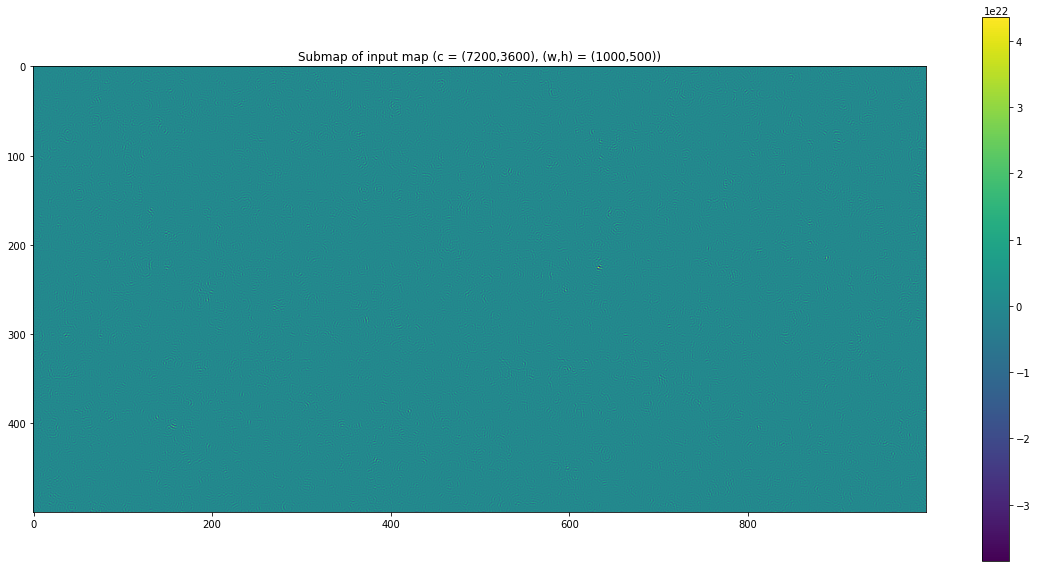

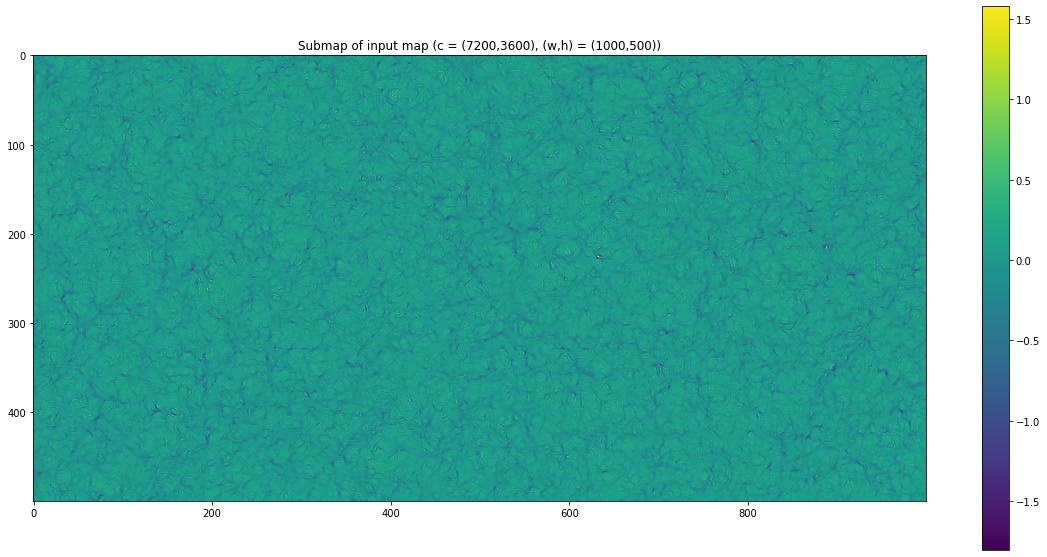

In [10]:
# enplot.plot(...,downgrade=8) 
plot = enplot.plot(kappa_map, downgrade=8)
enplot.show(plot)

josh_websky.plot_map(recon_map_only)
josh_websky.plot_map(kappa_map)

## Try stacking?

In [8]:
## generate convergence map from kap.fits file

# from given kap.fits file
RES = np.deg2rad(1.5 / 60.)
kap_px = josh_websky.px_to_car("../kap.fits", res=RES)
# filter similarly?
#kap_alms = map2alm(kap_px, lmax=LMAX)
#kap_fTalm = utils.isotropic_filter([kap_alms, kap_alms*0., kap_alms*0.],
#                                    tcls, lmin=LMIN, lmax=LMAX, ignore_te=True)[0]
kap_map = alm2map(map2alm(kap_px, lmax=LMAX), enmap.empty(shape, wcs, dtype=np.float32))
#kap_map = kap_px

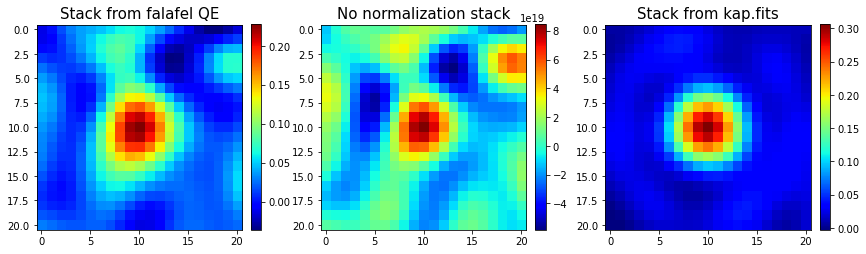

In [9]:
ra, dec = josh_websky.catalog_to_coords(filename="../halos_10x10.pksc")
RES = np.deg2rad(.5 / 60.)

# stack QE recon'd maps 
stack_map, avg_map = josh_websky.stack_average_random(kappa_map, ra, dec, Ncoords=100,
                                                      radius=10*RES, res=RES)

stack_recon, avg_recon = josh_websky.stack_average_random(recon_map_only, ra, dec, Ncoords=100,
                                                      radius=10*RES, res=RES)

# stack kap.fits convergence map
stack_kap, avg_kap = josh_websky.stack_average_random(kap_map, ra, dec, Ncoords=100,
                                                      radius=10*RES, res=RES)                                                     

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,36))

im1 = axes[0].imshow(avg_map, cmap='jet')
axes[0].set_title("Stack from falafel QE", fontsize=15)
im2 = axes[1].imshow(avg_recon, cmap='jet')
axes[1].set_title("No normalization stack", fontsize=15)
im3 = axes[2].imshow(avg_kap, cmap='jet')
axes[2].set_title("Stack from kap.fits", fontsize=15)

fig.subplots_adjust(right=0.85)
fig.colorbar(im1, ax = axes[0], fraction=0.046, pad=0.04)
fig.colorbar(im2, ax = axes[1], fraction=0.046, pad=0.04)
fig.colorbar(im3, ax = axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig("reconstruction-nophitokap.png")
plt.show()

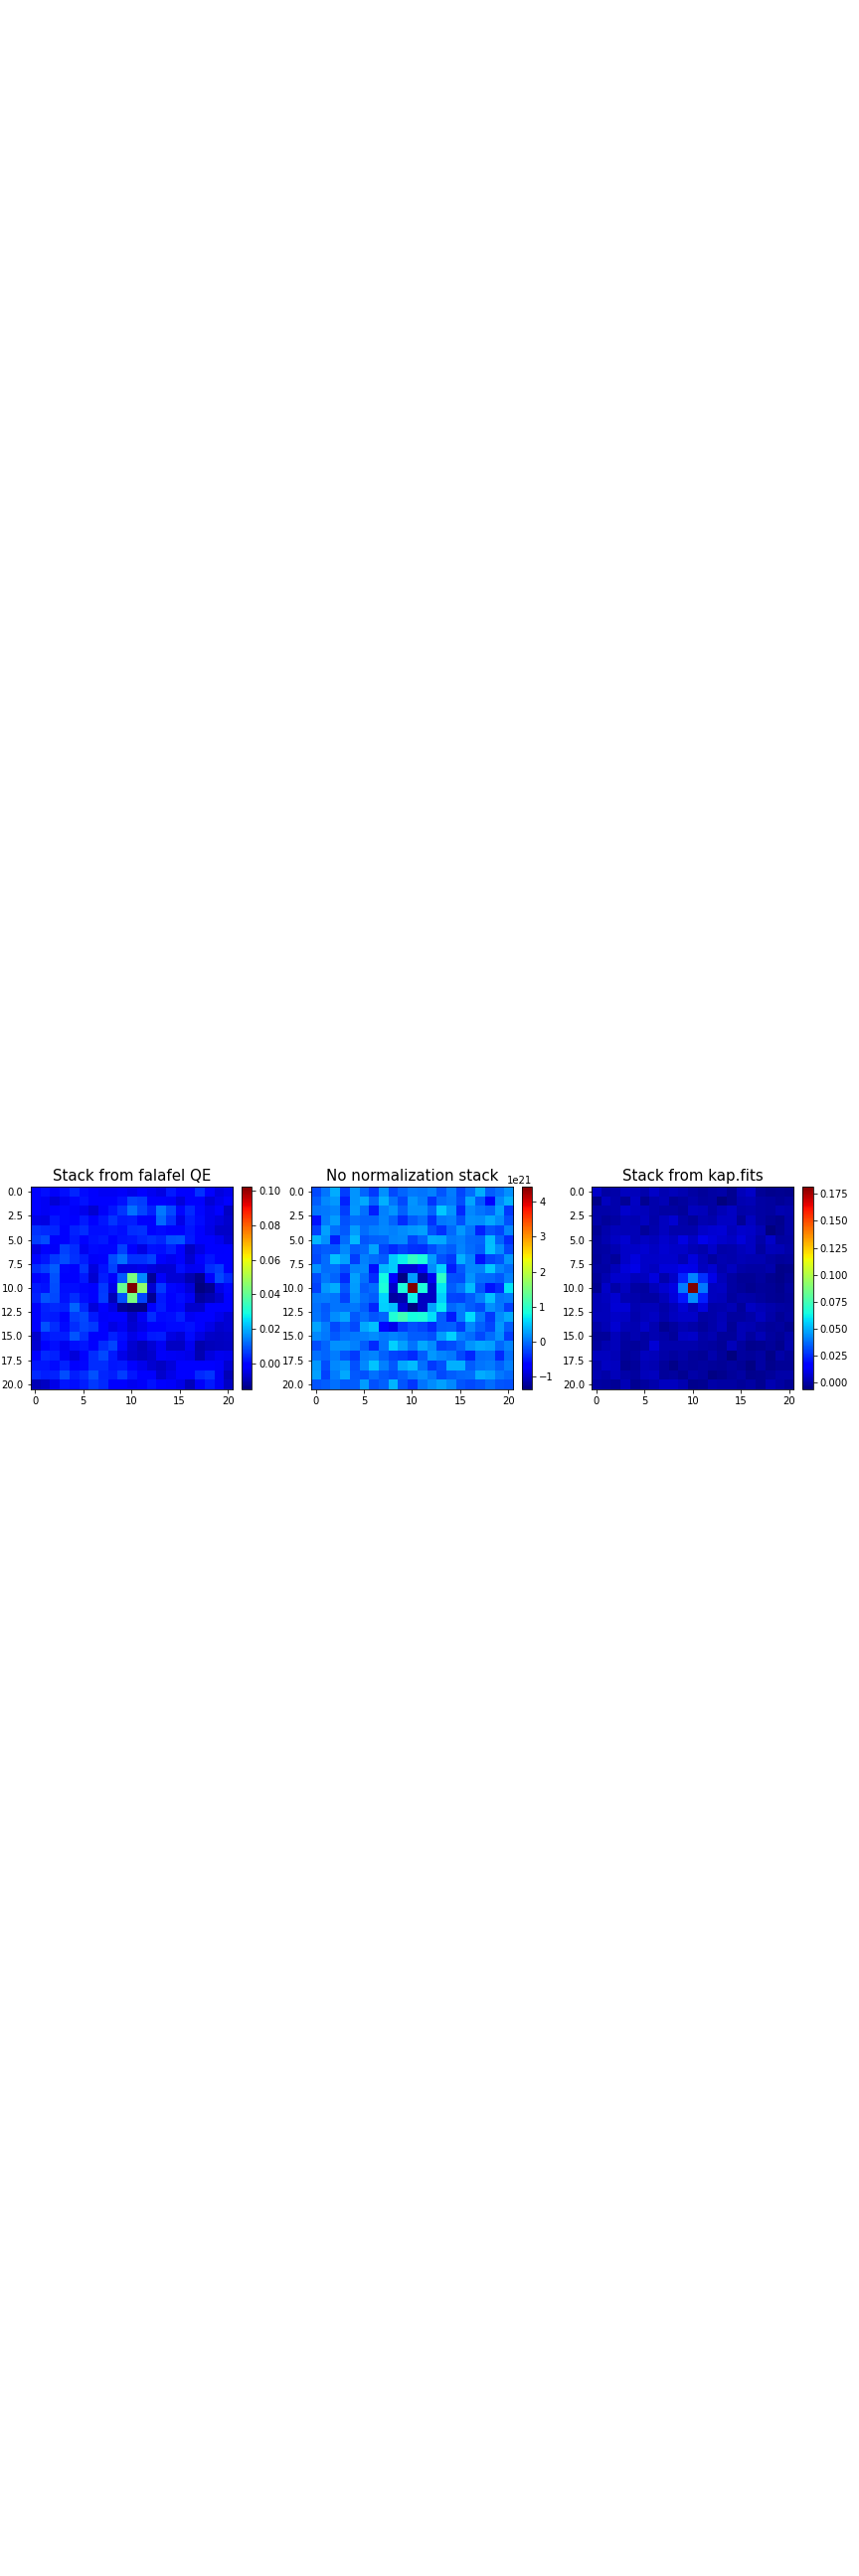

In [14]:
# using l = 6000, zero noise level
display.Image("reconstruction-zeroerror.png")

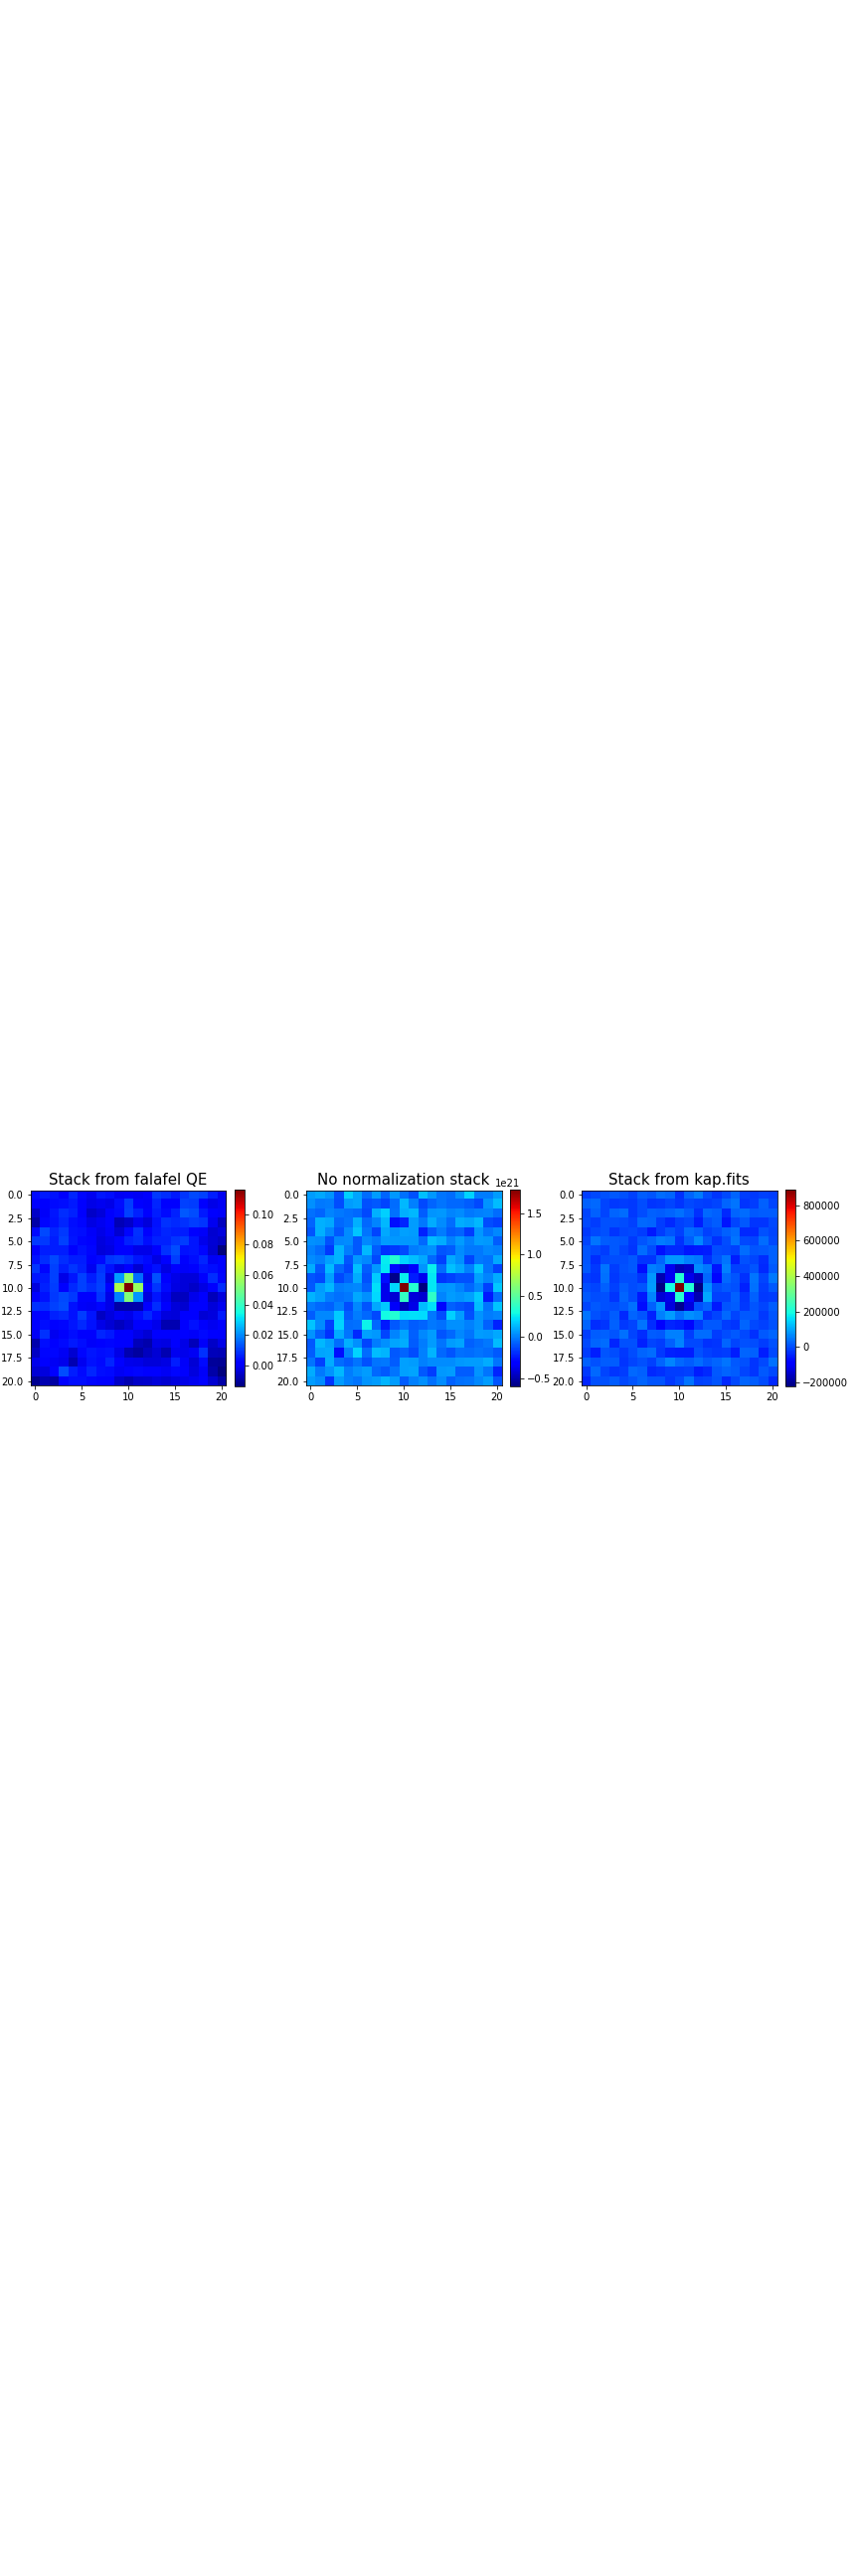

In [15]:
# with alm2map(phi_to_kappa(map2alm())
display.Image("reconstruction-lmax.png")

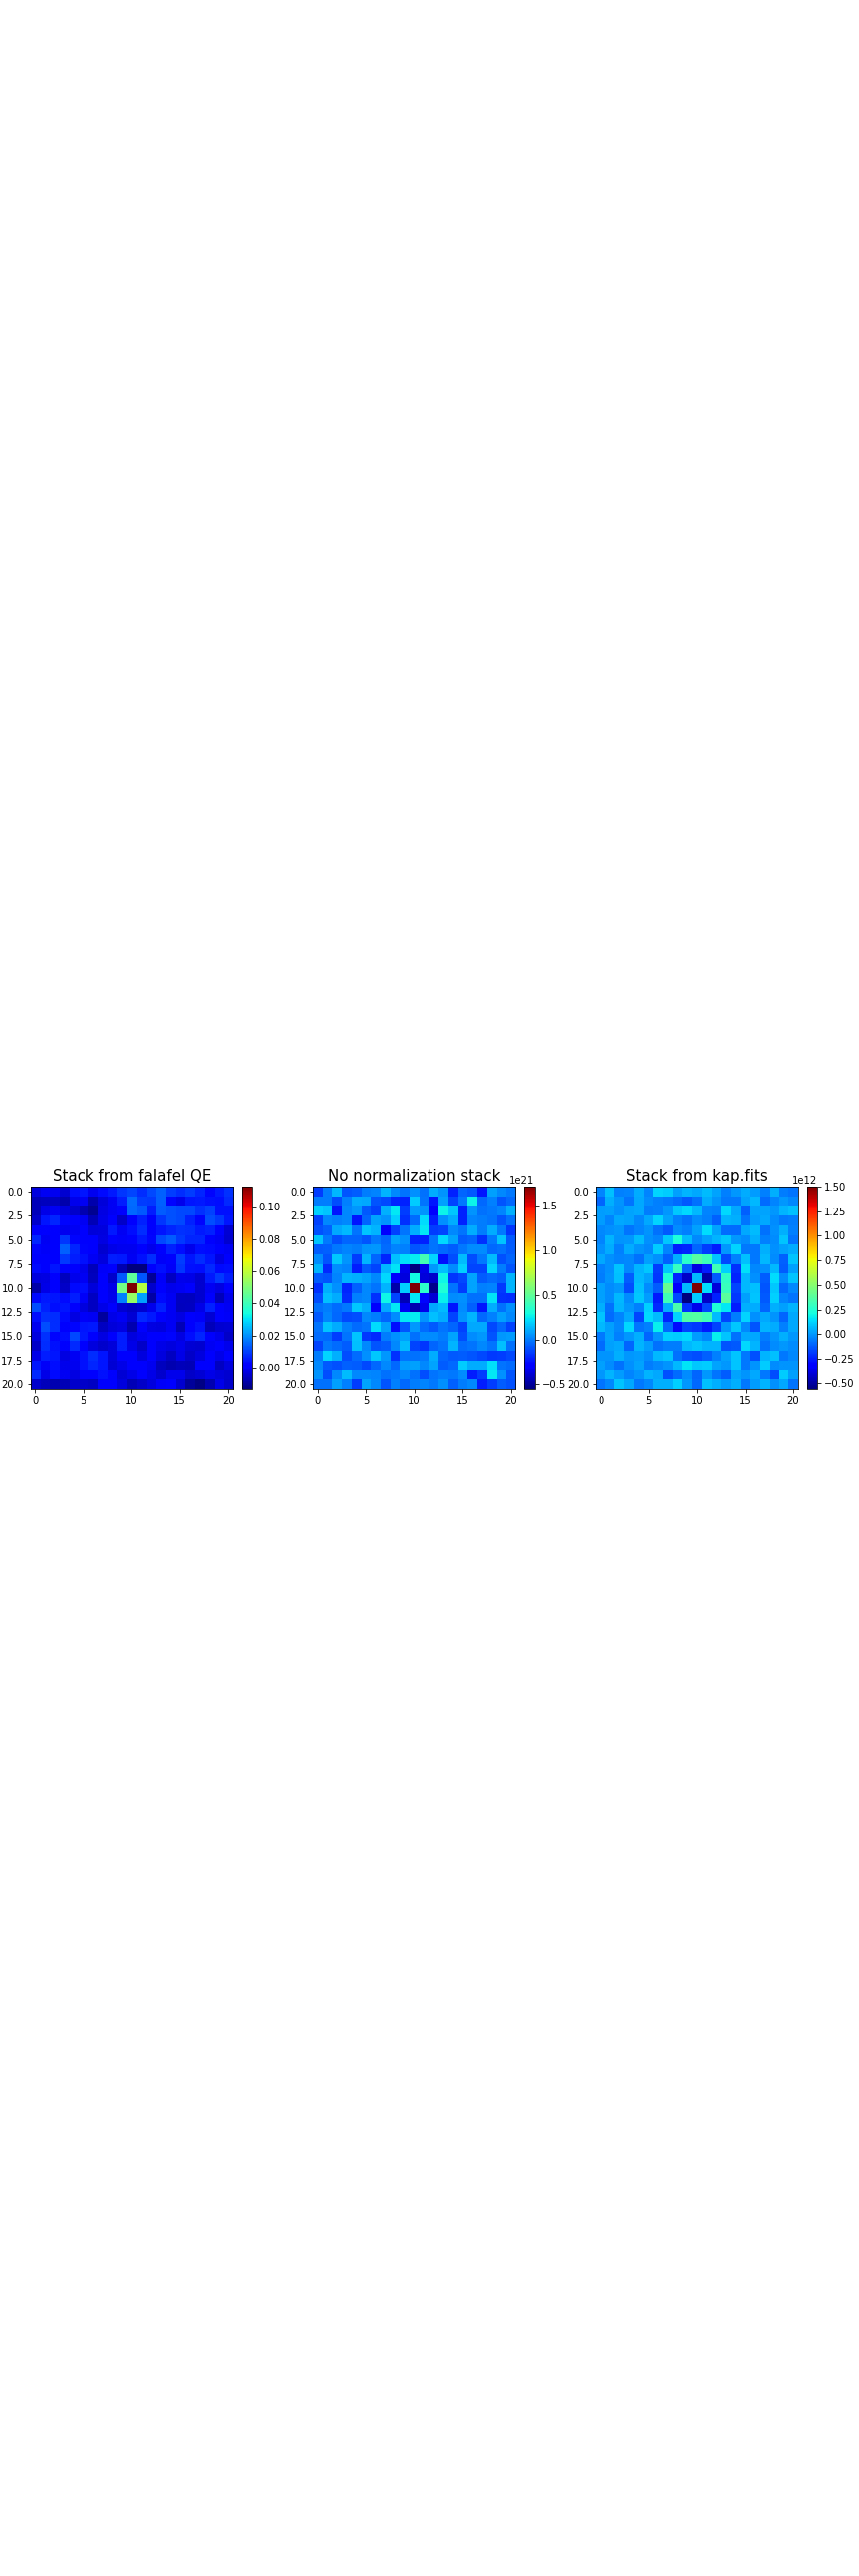

In [16]:
# using inverse-variance filtering applied onto the alms from map2alm
display.Image("reconstruction-isotropic.png")

## Using symlens

### Set-up to generate symlens normalizations

In [15]:
SYM_LMIN = 300
SYM_LMAX = 6000
SYM_GLMIN = 300
SYM_GLMAX = SYM_LMAX

sym_shape, sym_wcs = enmap.geometry(res=2.0 * putils.arcmin,pos=[0,0],shape=(1000,1000), proj='plain') 

kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_LMIN, lmax=SYM_LMAX)
g_kmask = sutils.mask_kspace(sym_shape, sym_wcs, lmin=SYM_GLMIN, lmax=SYM_GLMAX)

# generate a feed_dict
feed_dict = {}
feed_dict_grad = {}
NOISE_T = noise_t
BEAM_FWHM = beam_fwhm # arcmin?
modlmap = enmap.modlmap(sym_shape, sym_wcs)

# from falafel/utils.py
ells,gt,ge,gb,gte = np.loadtxt(f"{thloc}_camb_1.0.12_grads.dat",unpack=True,usecols=[0,1,2,3,4])

nells = (NOISE_T*np.pi/180./60.)**2. / sutils.gauss_beam(BEAM_FWHM,modlmap)**2.

#feed_dict_grad['uC_T_T'] = sutils.interp(ells, gt)(modlmap)
#feed_dict_grad['tC_T_T'] = feed_dict_grad['uC_T_T'] + nells
feed_dict['uC_T_T'] = theory.lCl('TT',modlmap)
feed_dict['tC_T_T'] = feed_dict['uC_T_T'] + nells

# generate normalization
s_norms = s.A_l(sym_shape, sym_wcs,feed_dict,"hdv","TT",xmask=g_kmask,ymask=kmask)

s_norms.shape

(1000, 1000)